In [1]:
import copy

import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# 自定义类，用于封装tif文件的操作
class TifFile:
    def __init__(self, file_path):
        self.file_path = file_path
        with rasterio.open(self.file_path) as src:
            self.data = src.read(1)  # 数值矩阵
            self.shape = self.data.shape  # 矩阵大小
            self.transform = src.transform  # 坐标变换参数
            self.crs = src.crs  # 坐标参考系统
            self.bounds = src.bounds  # 边界坐标
            self.width = src.width  # 宽度
            self.height = src.height  # 高度
            self.count = src.count  # 波段数


# 文件路径字典
file_paths = {
    "GLcBld_Height": "datasets/GLcBld_Height.tif",
    "glcent_CHM": "datasets/glcent_CHM.tif",
    "glcent_DSM": "datasets/glcent_DSM.tif",
    "KernelD_GLcB_new": "datasets/KernelD_GLcB_new.tif",
    "LAI": "datasets/LAI.tif"
}

# 动态创建TifFile实例并存储为全局变量
for variable_name, file_path in file_paths.items():
    tif_GLcBld_Height = TifFile('datasets/GLcBld_Height.tif')
    tif_glcent_CHM = TifFile('datasets/glcent_CHM.tif')
    tif_glcent_DSM = TifFile('datasets/glcent_DSM.tif')
    tif_KernelD_GLcB_new = TifFile('datasets/KernelD_GLcB_new.tif')
    tif_LAI = TifFile('datasets/LAI.tif')


# 数据信息了解

In [3]:
tif_GLcBld_Height.data

array([[65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16)

In [4]:
# 计算每个唯一值的数量
unique_values, counts = np.unique(tif_GLcBld_Height.data, return_counts=True)

# 根据计数进行排序，倒序排列
sorted_indices = np.argsort(counts)[::-1]

# 使用排序后的索引重新排序唯一值和计数
sorted_unique_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

# 打印倒序的结果
for value, count in zip(sorted_unique_values, sorted_counts):
    print(f"Value: {value}, Count: {count}")

Value: 65535, Count: 139282
Value: 109, Count: 1798
Value: 249, Count: 1338
Value: 294, Count: 1312
Value: 3, Count: 1113
Value: 205, Count: 822
Value: 342, Count: 698
Value: 96, Count: 584
Value: 340, Count: 552
Value: 154, Count: 534
Value: 315, Count: 528
Value: 195, Count: 510
Value: 232, Count: 497
Value: 299, Count: 482
Value: 268, Count: 479
Value: 233, Count: 473
Value: 170, Count: 437
Value: 104, Count: 433
Value: 110, Count: 421
Value: 215, Count: 394
Value: 280, Count: 380
Value: 75, Count: 376
Value: 269, Count: 374
Value: 175, Count: 374
Value: 210, Count: 370
Value: 243, Count: 357
Value: 67, Count: 346
Value: 40, Count: 345
Value: 140, Count: 343
Value: 30, Count: 340
Value: 333, Count: 339
Value: 157, Count: 335
Value: 98, Count: 335
Value: 139, Count: 331
Value: 270, Count: 321
Value: 242, Count: 321
Value: 145, Count: 319
Value: 106, Count: 319
Value: 39, Count: 317
Value: 63, Count: 315
Value: 180, Count: 313
Value: 16, Count: 308
Value: 244, Count: 305
Value: 21, Co

In [5]:
# 计算基本统计数据（此部分与前面代码相同）
mean_value = np.mean(tif_GLcBld_Height.data)
std_dev = np.std(tif_GLcBld_Height.data)
min_value = np.min(tif_GLcBld_Height.data)
max_value = np.max(tif_GLcBld_Height.data)

print("\nBasic Statistics:")
print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")


Basic Statistics:
Mean: 47696.188133956304
Standard Deviation: 29118.9257780749
Min: 1
Max: 65535


In [6]:
tif_GLcBld_Height.transform

Affine(5.0, 0.0, 257976.73599999957,
       0.0, -5.0, 666174.3099000007)

In [7]:
tif_GLcBld_Height.crs

CRS.from_epsg(27700)

In [8]:
tif_GLcBld_Height.bounds

BoundingBox(left=257976.73599999957, bottom=663899.3099000007, right=260081.73599999957, top=666174.3099000007)

In [9]:
tif_GLcBld_Height.width

421

In [10]:
tif_GLcBld_Height.height

455

In [11]:
tif_GLcBld_Height.count

1

In [12]:
tif_glcent_CHM.data

array([[28.882736  , 28.408676  , 27.841417  , ..., 15.216122  ,
        14.058662  ,  0.08586502],
       [31.331669  , 30.637243  , 31.719954  , ..., 13.888069  ,
        12.631687  ,  0.07413864],
       [31.908613  , 31.804506  , 32.027122  , ..., 10.486404  ,
         9.954441  ,  0.0562439 ],
       ...,
       [ 6.266613  ,  6.3237047 ,  1.4739332 , ..., 17.83626   ,
        18.70651   , 17.208393  ],
       [ 4.7787457 ,  1.4792271 ,  0.1911993 , ..., 12.996392  ,
        14.958178  , 18.35652   ],
       [ 0.25867653,  0.15101147,  0.16328621, ...,  0.0835458 ,
         0.13466549, 12.975633  ]], dtype=float32)

In [13]:
tif_list = [tif_GLcBld_Height, tif_glcent_CHM, tif_glcent_DSM, tif_KernelD_GLcB_new, tif_LAI]

# 创建一个空的列表，用于存储每个tif文件的属性
data = []

# 遍历每个TifFile对象，提取属性并存储到data列表中
data = [
    {
        "Name": tif.file_path.split('/')[-1],  # 提取文件名
        "Data": tif.data,
        "Data.shape": tif.shape,
        "Transform": tif.transform,
        "CRS": tif.crs,
        "Bounds": tif.bounds,
        "Width": tif.width,
        "Height": tif.height,
        "Band Count": tif.count
    }
    for tif in tif_list
]

# 将列表转换为DataFrame
df = pd.DataFrame(data)


In [14]:
df

,Name,Data,Data.shape,Transform,CRS,Bounds,Width,Height,Band Count
0,GLcBld_Height.tif,"[[65535, 65535, 65535, 65535, 65535, 65535, 65...","(455, 421)","(5.0, 0.0, 257976.73599999957, 0.0, -5.0, 6661...",(init),"(257976.73599999957, 663899.3099000007, 260081...",421,455,1
1,glcent_CHM.tif,"[[28.882736, 28.408676, 27.841417, 2.758522, 0...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
2,glcent_DSM.tif,"[[55.24, 54.737, 54.116, 28.998, 26.305, 36.85...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
3,KernelD_GLcB_new.tif,"[[244.3018, 275.4633, 306.76352, 337.6687, 367...","(245, 244)","(8.21323320000243, 0.0, 257999.8617497996, 0.0...",(init),"(257999.8617497996, 663991.944182601, 260003.8...",244,245,1
4,LAI.tif,"[[11.7030945, 11.513471, 11.286567, 1.2534088,...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1


In [15]:
A = tif_glcent_CHM
B = tif_GLcBld_Height
transform_A = A.transform
transform_B = B.transform
width_A = A.width
height_A = A.height
width_B = B.width
height_B = B.height

In [16]:
transform_A

Affine(5.0, 0.0, 258000.0,
       0.0, -5.0, 666000.0)

In [17]:
transform_B

Affine(5.0, 0.0, 257976.73599999957,
       0.0, -5.0, 666174.3099000007)

In [18]:
width_A

400

边界计算：
已知信息
A 的仿射变换: Affine(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0)
B 的仿射变换: Affine(5.0, 0.0, 257976.73599999997, 0.0, -5.0, 666174.3099999997)

A 的大小: width_A = 400，height_A = 400
B 的大小: width_B = 421，height_B = 455

计算边界（Bounding Box）
我们需要计算两个图像的空间范围（Bounding Box），即确定它们的左上角和右下角的地理坐标。

1. A 的边界
左上角（xmin_A, ymax_A）:
xmin_A = 258000.0
ymax_A = 666000.0
右下角（xmax_A, ymin_A）:
xmax_A = 258000.0 + 400 * 5.0 = 260000.0
ymin_A = 666000.0 + 400 * -5.0 = 664000.0
因此，A 的边界是：

(xmin_A, ymin_A, xmax_A, ymax_A) = (258000.0, 664000.0, 260000.0, 666000.0)
2. B 的边界
左上角（xmin_B, ymax_B）:
xmin_B = 257976.736
ymax_B = 666174.31
右下角（xmax_B, ymin_B）:
xmax_B = 257976.736 + 421 * 5.0 = 260081.736
ymin_B = 666174.31 + 455 * -5.0 = 663899.81
因此，B 的边界是：

(xmin_B, ymin_B, xmax_B, ymax_B) = (257976.736, 663899.81, 260081.736, 666174.31)

B完全覆盖A

In [19]:
# 读取 B 的文件
with rasterio.open('datasets/GLcBld_Height.tif') as src_B:
    # A 的边界
    xmin_A, ymin_A, xmax_A, ymax_A = 258000.0, 664000.0, 260000.0, 666000.0

    # 计算 B 中与 A 重叠的窗口
    window = from_bounds(xmin_A, ymin_A, xmax_A, ymax_A, transform=src_B.transform)

    # 获取窗口的行列偏移和大小
    col_off, row_off = window.col_off, window.row_off
    width, height = window.width, window.height

    # 打印裁剪范围相对于原始 B 图像的行列范围
    print(f"裁剪范围在原始 B 图像中的列偏移: {col_off}, 行偏移: {row_off}")
    print(f"裁剪范围的宽度: {width} 像素，高度: {height} 像素")
    print(f"裁剪范围结束的列号: {col_off + width}, 行号: {row_off + height}")

    # 读取窗口内的 B 的数据
    B_overlap_data = src_B.read(window=window)

    # 生成裁剪后的 B 数据
    profile = src_B.profile
    profile.update({
        "height": window.height,
        "width": window.width,
        "transform": rasterio.windows.transform(window, src_B.transform)
    })


裁剪范围在原始 B 图像中的列偏移: 4.652800000083516, 行偏移: 34.86198000013246
裁剪范围的宽度: 400.0 像素，高度: 400.0 像素
裁剪范围结束的列号: 404.6528000000835, 行号: 434.86198000013246


In [20]:
B_overlap_data

array([[[  181, 65535, 65535, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        ...,
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535]]], dtype=uint16)

In [21]:
C = B_overlap_data[0, :, :]

In [22]:
CHM_tif = copy.deepcopy(tif_glcent_CHM)
DSM_tif = copy.deepcopy(tif_glcent_DSM)
LAI_tif = copy.deepcopy(tif_LAI)
BH_tif = copy.deepcopy(tif_glcent_CHM)

In [23]:
BH_tif

In [24]:
BH_tif.data

array([[28.882736  , 28.408676  , 27.841417  , ..., 15.216122  ,
        14.058662  ,  0.08586502],
       [31.331669  , 30.637243  , 31.719954  , ..., 13.888069  ,
        12.631687  ,  0.07413864],
       [31.908613  , 31.804506  , 32.027122  , ..., 10.486404  ,
         9.954441  ,  0.0562439 ],
       ...,
       [ 6.266613  ,  6.3237047 ,  1.4739332 , ..., 17.83626   ,
        18.70651   , 17.208393  ],
       [ 4.7787457 ,  1.4792271 ,  0.1911993 , ..., 12.996392  ,
        14.958178  , 18.35652   ],
       [ 0.25867653,  0.15101147,  0.16328621, ...,  0.0835458 ,
         0.13466549, 12.975633  ]], dtype=float32)

In [25]:
B_overlap_data.shape

(1, 400, 400)

In [26]:

BH_tif.data = C
BH_tif.shape = C.shape

In [27]:
BH_tif.data

array([[  181, 65535, 65535, ..., 65535, 65535, 65535],
       [  181,   181,   181, ..., 65535, 65535, 65535],
       [  181,   181,   181, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16)

In [28]:
list_tif = [
    BH_tif,  # 建筑物高度
    CHM_tif,  # 树冠高度
    LAI_tif,  # 叶面积指数
    DSM_tif  # 地形数据   
]

data1 = []

# 遍历每个TifFile对象，提取属性并存储到data列表中
data1 = [
    {
        "Name": tif.file_path.split('/')[-1],  # 提取文件名
        "Data": tif.data,
        "Data.shape": tif.shape,
        "Transform": tif.transform,
        "CRS": tif.crs,
        "Bounds": tif.bounds,
        "Width": tif.width,
        "Height": tif.height,
        "Band Count": tif.count
    }
    for tif in list_tif
]

In [29]:
df = pd.DataFrame(data1)

In [30]:
df

,Name,Data,Data.shape,Transform,CRS,Bounds,Width,Height,Band Count
0,glcent_CHM.tif,"[[181, 65535, 65535, 65535, 65535, 65535, 6553...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
1,glcent_CHM.tif,"[[28.882736, 28.408676, 27.841417, 2.758522, 0...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
2,LAI.tif,"[[11.7030945, 11.513471, 11.286567, 1.2534088,...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1
3,glcent_DSM.tif,"[[55.24, 54.737, 54.116, 28.998, 26.305, 36.85...","(400, 400)","(5.0, 0.0, 258000.0, 0.0, -5.0, 666000.0, 0.0,...",(init),"(258000.0, 664000.0, 260000.0, 666000.0)",400,400,1


In [31]:
list_tifs = [BH_tif.data, CHM_tif.data, LAI_tif.data, DSM_tif.data]

In [32]:
list_tifs

[array([[  181, 65535, 65535, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        [  181,   181,   181, ..., 65535, 65535, 65535],
        ...,
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535],
        [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16),
 array([[28.882736  , 28.408676  , 27.841417  , ..., 15.216122  ,
         14.058662  ,  0.08586502],
        [31.331669  , 30.637243  , 31.719954  , ..., 13.888069  ,
         12.631687  ,  0.07413864],
        [31.908613  , 31.804506  , 32.027122  , ..., 10.486404  ,
          9.954441  ,  0.0562439 ],
        ...,
        [ 6.266613  ,  6.3237047 ,  1.4739332 , ..., 17.83626   ,
         18.70651   , 17.208393  ],
        [ 4.7787457 ,  1.4792271 ,  0.1911993 , ..., 12.996392  ,
         14.958178  , 18.35652   ],
        [ 0.25867653,  0.15101147,  0.16328621, ...,  0.0835458 ,
          0.13466549, 12.975633  ]], dty

# 网格数据差值

In [33]:
# 已知点的坐标和温度值
points = np.array([
    [0, 0],  # 点 A
    [1, 0],  # 点 B
    [0, 1]   # 点 C
])

temperatures = np.array([5, 6, 7])  # 点 A, B, C 的温度值

# 半变异矩阵
Gamma = np.array([
    [0, 1, 1, 1],          # 点 A 到 A, B, C 和约束条件
    [1, 0, np.sqrt(2), 1], # 点 B 到 A, B, C 和约束条件
    [1, np.sqrt(2), 0, 1], # 点 C 到 A, B, C 和约束条件
    [1, 1, 1, 0]           # 约束条件
])

# 目标点 P 的坐标
P = np.array([0.5, 0.5])

# 计算 P 到 A, B, C 的半变异函数值
gamma = np.array([
    np.sqrt(np.sum((P - points[0])**2)),  # 到 A 的距离
    np.sqrt(np.sum((P - points[1])**2)),  # 到 B 的距离
    np.sqrt(np.sum((P - points[2])**2)),  # 到 C 的距离
    1  # 约束条件
])

# 解克里金系统
lambdas = np.linalg.solve(Gamma, gamma)

# 提取权重
lambda_A, lambda_B, lambda_C, mu = lambdas

# 使用权重计算插值点 P 的温度值
Z_P = lambda_A * temperatures[0] + lambda_B * temperatures[1] + lambda_C * temperatures[2]

print(f"点 P (0.5, 0.5) 的估计温度值为: {Z_P:.2f}")


点 P (0.5, 0.5) 的估计温度值为: 6.16


In [34]:
# 输入6个点的坐标和天气数据值

# 提取的数据如下：
data_5_extra_points = [
    ['Renfrew Weather', (55.8739065, -4.3887910), (250756.73, 666880.47), '31/07/2024 09:30:00', 8.4, 17, 57, 0.4],
    ['Ralston Weather Station', (55.8466298, -4.3708027), (251848.22, 663740.00), '31/07/2024 09:30:00', 8.1, 11.8, 78.2, 0.9],
    ['Cathcart', (55.8114036, -4.2603826), (258548.22, 659684.28), '31/07/2024 09:28:07', 10, 15.9, 68, 0],
    ['Clincarthill', (55.8253972, -4.2119939), (261484.32, 661295.42), '31/07/2024 09:29:36', 9.3, 15.1, 68, 0.8],
    ['Cambuslang Scotland', (55.8253972, -4.2119939), (261484.32, 661295.42), '31/07/2024 09:31:36', 8.9, 13.4, 74, 0]
]

# 直接将数据列表转换为 Pandas DataFrame
columns = ['Location', 'A Coordinates (Lat, Lon)', 'B Coordinates (X_B, Y_B)', 'Report Date / Time', 'Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)']
df_5_extra_points = pd.DataFrame(data_5_extra_points, columns=columns)

# 显示 DataFrame
df_5_extra_points


,Location,"A Coordinates (Lat, Lon)","B Coordinates (X_B, Y_B)",Report Date / Time,Dew Point (°C),Air Temperature (°C),Relative Humidity (%),Wind Speed (kn)
0,Renfrew Weather,"(55.8739065, -4.388791)","(250756.73, 666880.47)",31/07/2024 09:30:00,8.4,17.0,57.0,0.4
1,Ralston Weather Station,"(55.8466298, -4.3708027)","(251848.22, 663740.0)",31/07/2024 09:30:00,8.1,11.8,78.2,0.9
2,Cathcart,"(55.8114036, -4.2603826)","(258548.22, 659684.28)",31/07/2024 09:28:07,10.0,15.9,68.0,0.0
3,Clincarthill,"(55.8253972, -4.2119939)","(261484.32, 661295.42)",31/07/2024 09:29:36,9.3,15.1,68.0,0.8
4,Cambuslang Scotland,"(55.8253972, -4.2119939)","(261484.32, 661295.42)",31/07/2024 09:31:36,8.9,13.4,74.0,0.0


In [35]:
# 从DataFrame中提取B坐标系的点和相关数据
B_points = np.array([item[2] for item in data_5_extra_points])
dew_points = np.array(df_5_extra_points['Dew Point (°C)'])
air_temps = np.array(df_5_extra_points['Air Temperature (°C)'])
humidity = np.array(df_5_extra_points['Relative Humidity (%)'])
wind_speeds = np.array(df_5_extra_points['Wind Speed (kn)'])


In [36]:
B_points

array([[250756.73, 666880.47],
       [251848.22, 663740.  ],
       [258548.22, 659684.28],
       [261484.32, 661295.42],
       [261484.32, 661295.42]])

In [37]:
dew_points

array([ 8.4,  8.1, 10. ,  9.3,  8.9])

In [38]:
air_temps

array([17. , 11.8, 15.9, 15.1, 13.4])

In [39]:
humidity

array([57. , 78.2, 68. , 68. , 74. ])

In [40]:
wind_speeds

array([0.4, 0.9, 0. , 0.8, 0. ])

In [41]:
# 定义网格
x_min, x_max = 258000, 260000
y_min, y_max = 664000, 666000
grid_x, grid_y = np.mgrid[x_min:x_max:400j, y_min:y_max:400j]
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T  # 是一个 (160000, 2) 的数组，保存了所有网格点的 (x, y) 坐标

In [42]:
grid_points

array([[258000.        , 664000.        ],
       [258000.        , 664005.01253133],
       [258000.        , 664010.02506266],
       ...,
       [260000.        , 665989.97493734],
       [260000.        , 665994.98746867],
       [260000.        , 666000.        ]])

In [43]:
# 定义半变异矩阵Gamma，简化处理为欧式距离
def compute_gamma(points, P):
    dist = np.sqrt(np.sum((points - P)**2, axis=1))
    return np.hstack([dist, 1])


In [44]:
# 函数：计算克里金插值
def kriging_interpolation(B_points, values, grid_points):
    # 构造Gamma矩阵
    n_points = len(B_points)
    Gamma = np.ones((n_points + 1, n_points + 1))
    for i in range(n_points):
        for j in range(n_points):
            Gamma[i, j] = np.sqrt(np.sum((B_points[i] - B_points[j])**2))

    # 添加一个小的正数扰动到对角线以避免奇异矩阵
    Gamma[np.diag_indices_from(Gamma)] += 1e-10

    Gamma[-1, -1] = 0

    # 插值结果存储
    interpolated_values = []

    for P in grid_points:
        gamma = compute_gamma(B_points, P)
        lambdas = np.linalg.solve(Gamma, gamma)
        interpolated_value = np.sum(lambdas[:-1] * values)
        interpolated_values.append(interpolated_value)

    return np.array(interpolated_values)


In [45]:
# 对每个变量进行插值
dew_point_grid = kriging_interpolation(B_points, dew_points, grid_points)
air_temp_grid = kriging_interpolation(B_points, air_temps, grid_points)
humidity_grid = kriging_interpolation(B_points, humidity, grid_points)
wind_speed_grid = kriging_interpolation(B_points, wind_speeds, grid_points)


In [46]:
# 将结果存储为DataFrame
grid_df = pd.DataFrame({
    'X': grid_points[:, 0],
    'Y': grid_points[:, 1],
    'Dew Point (°C)': dew_point_grid,
    'Air Temperature (°C)': air_temp_grid,
    'Relative Humidity (%)': humidity_grid,
    'Wind Speed (kn)': wind_speed_grid
})

In [47]:
grid_df

,X,Y,Dew Point (°C),Air Temperature (°C),Relative Humidity (%),Wind Speed (kn)
0,258000.0,664000.000000,8.999907,14.600371,69.439597,0.404868
1,258000.0,664005.012531,8.999255,14.600463,69.436530,0.405059
2,258000.0,664010.025063,8.998604,14.600558,69.433455,0.405249
3,258000.0,664015.037594,8.997953,14.600656,69.430372,0.405438
4,258000.0,664020.050125,8.997304,14.600757,69.427280,0.405627
...,...,...,...,...,...,...
159995,260000.0,665979.949875,8.868125,14.825202,67.820382,0.426470
159996,260000.0,665984.962406,8.867806,14.825854,67.816359,0.426516
159997,260000.0,665989.974937,8.867487,14.826507,67.812334,0.426562
159998,260000.0,665994.987469,8.867168,14.827160,67.808308,0.426608


In [48]:
# 匹配地形数据与天气数据的形状

# 展平地形数据
X = np.array([tif.ravel() for tif in list_tifs]).T # (160000, 4)

In [49]:
X

array([[1.81000000e+02, 2.88827362e+01, 1.17030945e+01, 5.52400017e+01],
       [6.55350000e+04, 2.84086761e+01, 1.15134706e+01, 5.47369995e+01],
       [6.55350000e+04, 2.78414173e+01, 1.12865667e+01, 5.41160011e+01],
       ...,
       [6.55350000e+04, 8.35458040e-02, 1.83418334e-01, 1.90300000e+00],
       [6.55350000e+04, 1.34665489e-01, 2.03866199e-01, 1.94400001e+00],
       [6.55350000e+04, 1.29756327e+01, 5.34025335e+00, 1.47709999e+01]],
      dtype=float32)

In [50]:
# 提取天气数据
Y = grid_df[['Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)']].values # (160000, 4)

In [51]:
Y

array([[ 8.99990701, 14.6003705 , 69.43959655,  0.40486841],
       [ 8.99925483, 14.600463  , 69.43653002,  0.40505876],
       [ 8.99860355, 14.60055833, 69.43345515,  0.40524862],
       ...,
       [ 8.86748666, 14.82650657, 67.81233419,  0.42656228],
       [ 8.86716808, 14.82715992, 67.80830767,  0.42660798],
       [ 8.86684982, 14.82781394, 67.80427948,  0.42665352]])

In [52]:
X

array([[1.81000000e+02, 2.88827362e+01, 1.17030945e+01, 5.52400017e+01],
       [6.55350000e+04, 2.84086761e+01, 1.15134706e+01, 5.47369995e+01],
       [6.55350000e+04, 2.78414173e+01, 1.12865667e+01, 5.41160011e+01],
       ...,
       [6.55350000e+04, 8.35458040e-02, 1.83418334e-01, 1.90300000e+00],
       [6.55350000e+04, 1.34665489e-01, 2.03866199e-01, 1.94400001e+00],
       [6.55350000e+04, 1.29756327e+01, 5.34025335e+00, 1.47709999e+01]],
      dtype=float32)

In [53]:
Y

array([[ 8.99990701, 14.6003705 , 69.43959655,  0.40486841],
       [ 8.99925483, 14.600463  , 69.43653002,  0.40505876],
       [ 8.99860355, 14.60055833, 69.43345515,  0.40524862],
       ...,
       [ 8.86748666, 14.82650657, 67.81233419,  0.42656228],
       [ 8.86716808, 14.82715992, 67.80830767,  0.42660798],
       [ 8.86684982, 14.82781394, 67.80427948,  0.42665352]])

In [54]:
# # 构建存储结果的表格
# importance_matrix = np.zeros((4, 4))

In [55]:
# from sklearn.ensemble import RandomForestRegressor

In [56]:
# # 对每一个Y参数构建随机森林模型并计算重要性
# for i in range(4):
#     y = Y[:, i]  # 第 i 个 Y 参数
#     model = RandomForestRegressor(n_estimators=100, random_state=42)
#     model.fit(X, y)
#     importance_matrix[:, i] = model.feature_importances_

In [57]:
# model

In [58]:
# # 将结果转化为DataFrame以便显示
# importance_df = pd.DataFrame(importance_matrix,
#                              columns=['Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)'],
#                              index=['建筑物高度', '树冠高度', '叶面积指数', '地形数据'])


In [59]:
# 显示结果
# importance_df

In [60]:
# 读取数据
X 

array([[1.81000000e+02, 2.88827362e+01, 1.17030945e+01, 5.52400017e+01],
       [6.55350000e+04, 2.84086761e+01, 1.15134706e+01, 5.47369995e+01],
       [6.55350000e+04, 2.78414173e+01, 1.12865667e+01, 5.41160011e+01],
       ...,
       [6.55350000e+04, 8.35458040e-02, 1.83418334e-01, 1.90300000e+00],
       [6.55350000e+04, 1.34665489e-01, 2.03866199e-01, 1.94400001e+00],
       [6.55350000e+04, 1.29756327e+01, 5.34025335e+00, 1.47709999e+01]],
      dtype=float32)

In [61]:
Y

array([[ 8.99990701, 14.6003705 , 69.43959655,  0.40486841],
       [ 8.99925483, 14.600463  , 69.43653002,  0.40505876],
       [ 8.99860355, 14.60055833, 69.43345515,  0.40524862],
       ...,
       [ 8.86748666, 14.82650657, 67.81233419,  0.42656228],
       [ 8.86716808, 14.82715992, 67.80830767,  0.42660798],
       [ 8.86684982, 14.82781394, 67.80427948,  0.42665352]])

In [62]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from datetime import datetime

In [67]:
# 定义进度条回调函数
class TqdmProgressCallback:
    def __init__(self, total_iterations, model_idx):
        self.pbar = tqdm(total=total_iterations, desc=f"Optimizing Model {model_idx+1}")

    def __call__(self, result):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

In [68]:
# 定义随机森林的超参数搜索空间
search_space = {
    'n_estimators': Integer(100, 300),  # 决策树数量
    'max_depth': Integer(10, 30),  # 最大深度
    'max_features': Categorical(['sqrt', 'log2', None]), # 最大特征数，None表示使用所有特征
    'min_samples_split': Integer(2, 10),  # 最小分裂样本数
    'min_samples_leaf': Integer(1, 4),  # 最小叶子节点样本数
    # 'bootstrap': Categorical([True])  # 由于袋外估计必须使用自助采样法，因此固定其值
}


In [69]:
# 初始化随机森林模型
model = RandomForestRegressor(random_state=42, oob_score=True)

# 用于存储每个模型的结果
# all_results = []
best_metrics_results = []

# 用于储存模型的特征重要性
importance_matrix = np.zeros((4, 4))

n_iter = 10  # 迭代次数


In [70]:
scoring = {
    'mse': 'neg_mean_squared_error',  # Mean Squared Error 均方误差
    'r2': 'r2',  # R² Coefficient of Determination 决定系数
    'mae': 'neg_mean_absolute_error',  # Mean Absolute Error 平均绝对误差
}

In [71]:
# 使用贝叶斯优化进行超参数搜索
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=n_iter,  # 迭代次数
    cv=5,  # 5 折交叉验证
    n_jobs=-1,  # 使用所有可用的核
    verbose=0,  # 显示详细信息
    scoring=scoring, # 评分标准
    refit='r2' # 使用负均方误差作为评分, 这样scoring里的值都会被计算和储存，但是只使用mse作为优化标准
)

In [72]:
%%time
# 开始贝叶斯优化并找到最佳参数
print("Optimizing model")
progress_callback = TqdmProgressCallback(total_iterations=n_iter, model_idx=0)

# 第一次贝叶斯优化
print('----------start fit----------')
bayes_search.fit(X, Y[:, 0], callback=[progress_callback])
print('----------end fit----------')

# 显式关闭进度条
progress_callback.close()


Optimizing model


Optimizing Model 1:   0%|          | 0/10 [00:00<?, ?it/s]

----------start fit----------


Optimizing Model 1: 100%|██████████| 10/10 [08:22<00:00, 50.20s/it]

----------end fit----------
CPU times: total: 8.33 s
Wall time: 8min 22s


In [73]:
# 提取优化后的最佳参数
best_params = bayes_search.best_params_

In [74]:
# 打印最佳参数
best_params

OrderedDict([('max_depth', 12),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 7),
             ('n_estimators', 131)])

In [75]:
# 
bayes_search.cv_results_

{'mean_fit_time': array([26.07102556, 26.71393347, 21.49452224, 23.38263097, 91.12862883,
        40.28856587, 50.70873618, 54.05480943, 76.77693958, 42.47910185]),
 'std_fit_time': array([0.58751919, 0.19123942, 0.1800638 , 0.19335246, 1.98492229,
        0.63811943, 0.21464187, 0.355173  , 1.4140623 , 0.52541784]),
 'mean_score_time': array([0.40677166, 0.32974148, 0.24988723, 0.26383009, 0.7181982 ,
        0.49058671, 0.52025318, 0.66630697, 1.04722819, 0.58329701]),
 'std_score_time': array([0.0364561 , 0.02341175, 0.02589138, 0.0341603 , 0.14900128,
        0.1772154 , 0.04330057, 0.07262198, 0.15634196, 0.07996702]),
 'param_max_depth': masked_array(data=[27, 15, 12, 12, 18, 12, 12, 14, 19, 19],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_max_features': masked_array(data=['log2', 'sqrt', 'log2', 'sqrt', None, 'log2', 'log2',
                    'log2', 'sqrt', 'log2'],
        

## 储存某次的R2标准优化结果
{'mean_fit_time': array([26.07102556, 26.71393347, 21.49452224, 23.38263097, 91.12862883,
        40.28856587, 50.70873618, 54.05480943, 76.77693958, 42.47910185]),
 'std_fit_time': array([0.58751919, 0.19123942, 0.1800638 , 0.19335246, 1.98492229,
        0.63811943, 0.21464187, 0.355173  , 1.4140623 , 0.52541784]),
 'mean_score_time': array([0.40677166, 0.32974148, 0.24988723, 0.26383009, 0.7181982 ,
        0.49058671, 0.52025318, 0.66630697, 1.04722819, 0.58329701]),
 'std_score_time': array([0.0364561 , 0.02341175, 0.02589138, 0.0341603 , 0.14900128,
        0.1772154 , 0.04330057, 0.07262198, 0.15634196, 0.07996702]),
 'param_max_depth': masked_array(data=[27, 15, 12, 12, 18, 12, 12, 14, 19, 19],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_max_features': masked_array(data=['log2', 'sqrt', 'log2', 'sqrt', None, 'log2', 'log2',
                    'log2', 'sqrt', 'log2'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[2, 2, 2, 2, 3, 1, 2, 4, 3, 4],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_min_samples_split': masked_array(data=[8, 9, 8, 7, 8, 7, 8, 4, 2, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[107, 143, 130, 131, 200, 206, 276, 274, 291, 165],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'params': [OrderedDict([('max_depth', 27),
               ('max_features', 'log2'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 8),
               ('n_estimators', 107)]),
  OrderedDict([('max_depth', 15),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 9),
               ('n_estimators', 143)]),
  OrderedDict([('max_depth', 12),
               ('max_features', 'log2'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 8),
               ('n_estimators', 130)]),
  OrderedDict([('max_depth', 12),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 7),
               ('n_estimators', 131)]),
  OrderedDict([('max_depth', 18),
               ('max_features', None),
               ('min_samples_leaf', 3),
               ('min_samples_split', 8),
               ('n_estimators', 200)]),
  OrderedDict([('max_depth', 12),
               ('max_features', 'log2'),
               ('min_samples_leaf', 1),
               ('min_samples_split', 7),
               ('n_estimators', 206)]),
  OrderedDict([('max_depth', 12),
               ('max_features', 'log2'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 8),
               ('n_estimators', 276)]),
  OrderedDict([('max_depth', 14),
               ('max_features', 'log2'),
               ('min_samples_leaf', 4),
               ('min_samples_split', 4),
               ('n_estimators', 274)]),
  OrderedDict([('max_depth', 19),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 3),
               ('min_samples_split', 2),
               ('n_estimators', 291)]),
  OrderedDict([('max_depth', 19),
               ('max_features', 'log2'),
               ('min_samples_leaf', 4),
               ('min_samples_split', 8),
               ('n_estimators', 165)])],
               
 'split0_test_mse': array([-0.00315614, -0.00304637, -0.00296848, -0.00298067, -0.00334233,
        -0.00297517, -0.00297619, -0.00300798, -0.00309799, -0.00307356]),
 'split1_test_mse': array([-0.00370179, -0.00323214, -0.00294446, -0.00294966, -0.00373365,
        -0.00294474, -0.00294214, -0.00315056, -0.00354496, -0.00350152]),
 'split2_test_mse': array([-0.00329228, -0.0031505 , -0.00312291, -0.00311261, -0.00327422,
        -0.00311226, -0.00312117, -0.0031527 , -0.00320675, -0.00319703]),
 'split3_test_mse': array([-0.00306912, -0.00286618, -0.00278685, -0.00278481, -0.00302339,
        -0.00279229, -0.00278954, -0.00284625, -0.00295531, -0.00295478]),
 'split4_test_mse': array([-0.00406558, -0.00375271, -0.00361434, -0.00358927, -0.00394   ,
        -0.00361365, -0.00360033, -0.00369968, -0.00388831, -0.00389908]),
 'mean_test_mse': array([-0.00345698, -0.00320958, -0.00308741, -0.0030834 , -0.00346272,
        -0.00308762, -0.00308587, -0.00317144, -0.00333866, -0.00332519]),
 'std_test_mse': array([0.00037374, 0.00029784, 0.00028419, 0.00027362, 0.00032992,
        0.00028199, 0.000278  , 0.00028716, 0.00033673, 0.00033982]),
 'rank_test_mse': array([ 9,  6,  3,  1, 10,  4,  2,  5,  8,  7]),
 
 'split0_test_r2': array([ 0.03451881,  0.06809758,  0.09192472,  0.08819461, -0.02243755,
         0.0898783 ,  0.089565  ,  0.07984007,  0.05230548,  0.0597796 ]),
 'split1_test_r2': array([-0.18605054, -0.0355737 ,  0.05659592,  0.05493211, -0.19626001,
         0.05650702,  0.05734193, -0.00943663, -0.13580233, -0.12188438]),
 'split2_test_r2': array([-0.14462087, -0.09532827, -0.08573688, -0.08215639, -0.13834277,
        -0.08203328, -0.08513211, -0.0960946 , -0.11488502, -0.11150438]),
 'split3_test_r2': array([-0.19930918, -0.12000913, -0.08900767, -0.08821273, -0.18144168,
        -0.0911352 , -0.09006017, -0.11222143, -0.15483654, -0.15462901]),
 'split4_test_r2': array([-0.84665504, -0.70454527, -0.64169711, -0.63030767, -0.78961784,
        -0.64138333, -0.6353334 , -0.68046095, -0.76613659, -0.77102759]),
 'mean_test_r2': array([-0.26842336, -0.17747176, -0.1335842 , -0.13151001, -0.26561997,
        -0.1336333 , -0.13272375, -0.16367471, -0.223871  , -0.21985315]),
 'std_test_r2': array([0.3010033 , 0.27140205, 0.26437773, 0.25928376, 0.26900102,
        0.26396573, 0.26162525, 0.26734673, 0.2809716 , 0.28550981]),
 'rank_test_r2': array([10,  6,  3,  1,  9,  4,  2,  5,  8,  7]),
 
 'split0_test_mae': array([-0.04216796, -0.04117714, -0.04068462, -0.04072028, -0.04330805,
        -0.04064553, -0.04073971, -0.04090927, -0.04166152, -0.04147892]),
 'split1_test_mae': array([-0.04868957, -0.04617966, -0.04474882, -0.04476162, -0.04889007,
        -0.0447271 , -0.0446924 , -0.04576071, -0.04785136, -0.04762282]),
 'split2_test_mae': array([-0.04759627, -0.04734019, -0.04758768, -0.04750625, -0.04737072,
        -0.04741837, -0.04755545, -0.04753451, -0.0473335 , -0.04730911]),
 'split3_test_mae': array([-0.04663049, -0.04538724, -0.04489832, -0.04487014, -0.04644633,
        -0.04494134, -0.04489243, -0.04526631, -0.04599692, -0.04598231]),
 'split4_test_mae': array([-0.05376062, -0.05260743, -0.0520376 , -0.05179902, -0.05304619,
        -0.05204619, -0.05194746, -0.05238508, -0.05304927, -0.05314944]),
 'mean_test_mae': array([-0.04776898, -0.04653833, -0.04599141, -0.04593146, -0.04781227,
        -0.0459557 , -0.04596549, -0.04637118, -0.04717851, -0.04710852]),
 'std_test_mae': array([0.00372679, 0.00367894, 0.0037418 , 0.00364855, 0.00319075,
        0.00374085, 0.00369846, 0.00371339, 0.00365447, 0.00373519]),
 'rank_test_mae': array([ 9,  6,  4,  1, 10,  2,  3,  5,  8,  7])}




bayes_search.cv_results_={
 'mean_fit_time': array([ 28.55289884, 155.50317574,  52.50600681,  91.00274124,
         66.90605783,  23.31525884,  74.57730494,  23.05400348,
         44.88403435,  39.85511346]),
 'std_fit_time': array([0.54538374, 7.96362842, 0.64139296, 1.40312096, 1.6577354 ,
        0.30543965, 0.77421921, 0.1786838 , 2.19447796, 0.61888006]),
 'mean_score_time': array([0.43226819, 1.38214898, 0.56199446, 1.42403045, 0.95648804,
        0.27831697, 1.14831452, 0.23273978, 0.55242758, 0.50476799]),
 'std_score_time': array([0.01843124, 0.14913223, 0.05973453, 0.25503474, 0.11458144,
        0.08118022, 0.10377971, 0.0228234 , 0.0392118 , 0.06492125]),
 'param_max_depth': masked_array(data=[22, 30, 13, 28, 30, 12, 20, 11, 14, 14],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_max_features': masked_array(data=['sqrt', None, 'log2', 'sqrt', 'log2', 'log2', 'sqrt',
                    'log2', 'log2', 'sqrt'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[2, 2, 2, 1, 4, 4, 2, 4, 1, 4],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_min_samples_split': masked_array(data=[7, 6, 9, 4, 8, 6, 4, 4, 5, 3],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[122, 299, 280, 288, 232, 122, 294, 143, 214, 208],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'params': [OrderedDict([('max_depth', 22),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 7),
               ('n_estimators', 122)]),
  OrderedDict([('max_depth', 30),
               ('max_features', None),
               ('min_samples_leaf', 2),
               ('min_samples_split', 6),
               ('n_estimators', 299)]),
  OrderedDict([('max_depth', 13),
               ('max_features', 'log2'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 9),
               ('n_estimators', 280)]),
  OrderedDict([('max_depth', 28),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 1),
               ('min_samples_split', 4),
               ('n_estimators', 288)]),
  OrderedDict([('max_depth', 30),
               ('max_features', 'log2'),
               ('min_samples_leaf', 4),
               ('min_samples_split', 8),
               ('n_estimators', 232)]),
  OrderedDict([('max_depth', 12),
               ('max_features', 'log2'),
               ('min_samples_leaf', 4),
               ('min_samples_split', 6),
               ('n_estimators', 122)]),
  OrderedDict([('max_depth', 20),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 4),
               ('n_estimators', 294)]),
  OrderedDict([('max_depth', 11),
               ('max_features', 'log2'),
               ('min_samples_leaf', 4),
               ('min_samples_split', 4),
               ('n_estimators', 143)]),
  OrderedDict([('max_depth', 14),
               ('max_features', 'log2'),
               ('min_samples_leaf', 1),
               ('min_samples_split', 5),
               ('n_estimators', 214)]),
  OrderedDict([('max_depth', 14),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 4),
               ('min_samples_split', 3),
               ('n_estimators', 208)])],
 'split0_test_mse': array([-0.00314969, -0.003404  , -0.00299522, -0.00320047, -0.00309079,
        -0.00297859, -0.00314615, -0.00293712, -0.00305422, -0.00301126]),
 'split1_test_mse': array([-0.00367954, -0.0039521 , -0.00304658, -0.00379419, -0.00366611,
        -0.00295142, -0.00361088, -0.00284054, -0.0031712 , -0.00314926]),
 'split2_test_mse': array([-0.00325977, -0.00342563, -0.0031388 , -0.00335028, -0.00329055,
        -0.00311705, -0.00322929, -0.00310303, -0.00314138, -0.00315347]),
 'split3_test_mse': array([-0.00301282, -0.00318465, -0.00281375, -0.00310288, -0.00305586,
        -0.00279048, -0.00298284, -0.0027541 , -0.00284909, -0.00284888]),
 'split4_test_mse': array([-0.00397664, -0.00420554, -0.00364901, -0.00413234, -0.00407106,
        -0.00360221, -0.00394333, -0.00353378, -0.00371502, -0.00370656]),
 'mean_test_mse': array([-0.00341569, -0.00363438, -0.00312867, -0.00351603, -0.00343487,
        -0.00308795, -0.0033825 , -0.00303372, -0.00318618, -0.00317389]),
 'std_test_mse': array([0.00035823, 0.00038107, 0.00028092, 0.00038858, 0.00038499,
        0.00027727, 0.00034807, 0.00027557, 0.00028738, 0.00028874]),
 'rank_test_mse': array([ 7, 10,  3,  9,  8,  2,  6,  1,  5,  4]),
 

splitX_test_mse：
- 含义：split0_test_mse、split1_test_mse 等是不同折交叉验证中，在每一折上对测试集计算的均方误差（MSE）。其中的 X 表示折数（从0开始）。
- 负号的原因：Scikit-Learn 在进行优化时，通常希望最大化评分。因此，对于需要最小化的损失函数（如MSE），Scikit-Learn 会将其存储为负值，以便与其他评分方式（如R²）一致地进行优化。
- 值：这些数组中的每个值对应于一个超参数组合在该折交叉验证中的MSE。

mean_test_mse：
- 含义：这是所有交叉验证折的测试集均方误差（MSE）的平均值。该值通常用于评估每个超参数组合的整体表现。
- 负号的原因：同样，MSE 是损失函数，因此 Scikit-Learn 存储其为负值以便于优化。你可以通过取反来得到实际的均方误差。

std_test_mse：
- 含义：这是在所有交叉验证折上计算的 MSE 标准差，表示该超参数组合在不同交叉验证折之间的表现一致性。较小的标准差表示该超参数组合在不同数据集上表现更一致。
- 值：这些值是标准差，用于衡量模型在不同折上的表现波动。

rank_test_mse：
- 含义：这是根据 mean_test_mse 对所有超参数组合进行排序后的排名。1 表示表现最好的参数组合，数字越大表示表现越差。
- 值：这些值是排名，用于快速识别最佳的参数组合。

 'split0_test_r2': array([ 0.03649199, -0.04130479,  0.08374358,  0.02095808,  0.05451029,
         0.08883226,  0.03757433,  0.10151746,  0.06569649,  0.07883888]),
 'split1_test_r2': array([-0.17892284, -0.26625028,  0.02387768, -0.21565647, -0.17461737,
         0.0543681 , -0.15692174,  0.08989159, -0.01605045, -0.00902198]),
 'split2_test_r2': array([-0.13331823, -0.19098099, -0.09126124, -0.1647846 , -0.14401791,
        -0.08370052, -0.1227201 , -0.07882384, -0.09215823, -0.09636228]),
 'split3_test_r2': array([-0.17730976, -0.24445503, -0.09952139, -0.21250353, -0.19412785,
        -0.09042801, -0.1655939 , -0.07621163, -0.11332923, -0.11324614]),
 'split4_test_r2': array([-0.80625985, -0.910231  , -0.65744157, -0.87698071, -0.84914693,
        -0.63618698, -0.7911284 , -0.6051059 , -0.68742769, -0.68358576]),
 'mean_test_r2': array([-0.25186374, -0.33064442, -0.14812059, -0.28979345, -0.26147995,
        -0.13342303, -0.23975796, -0.11374646, -0.16865382, -0.16467546]),
 'std_test_r2': array([0.28824843, 0.30023961, 0.26394966, 0.30608908, 0.30694659,
        0.2614404 , 0.28530074, 0.25763135, 0.26692567, 0.26836796]),
 'rank_test_r2': array([ 7, 10,  3,  9,  8,  2,  6,  1,  5,  4]),
 
splitX_test_r2：
- 含义：split0_test_r2、split1_test_r2 等是不同折交叉验证中，在每一折上对测试集计算的 R² 分数。其中的 X 表示折数（从0开始）。
- 值：这些数组中的每个值对应于一个超参数组合在该折交叉验证中的 R² 分数。
- 解释各个 R² 分数的含义：
    - R² 取值大于 0：表示模型能够解释一部分方差，值越接近 1，表示模型拟合得越好。
    - R² 取值等于 0：表示模型的预测能力和简单的平均值模型一样。
    - R² 取值小于 0：表示模型的表现还不如直接用平均值预测好，这通常意味着模型不适合当前数据。
- 在你的结果中，splitX_test_r2 的某些值为负，这意味着在某些折上，模型的预测效果还不如简单地用目标变量的平均值进行预测。这可能表明模型过拟合、欠拟合，或者数据本身具有很高的噪声。





mean_test_r2：
- 含义：这是所有交叉验证折的 R² 分数的平均值。该值通常用于评估每个超参数组合的整体表现。
- 值：mean_test_r2 反映了模型在交叉验证过程中总体上的拟合优度。负值表示模型总体上并没有很好地拟合数据。

std_test_r2：
- 含义：这是在所有交叉验证折上计算的 R² 分数的标准差，表示该超参数组合在不同交叉验证折之间的表现一致性。较小的标准差表示该超参数组合在不同数据集上表现更一致。
- 值：std_test_r2 的值越小，表示模型在不同折上的表现波动越小，模型的稳定性更好。

rank_test_r2：
- 含义：这是根据 mean_test_r2 对所有超参数组合进行排序后的排名。1 表示表现最好的参数组合，数字越大表示表现越差。
- 值：rank_test_r2 的值用于快速识别最佳的参数组合。排名为 1 的组合是 R² 分数表现最好的组合。

 'split0_test_mae': array([-0.04200953, -0.04376363, -0.04087904, -0.04236879, -0.04154537,
        -0.04079124, -0.04199233, -0.04052508, -0.04124006, -0.04094894]),
 'split1_test_mae': array([-0.04860571, -0.05002574, -0.04522395, -0.04920039, -0.0485336 ,
        -0.044706  , -0.0482044 , -0.0442033 , -0.04592036, -0.04575566]),
 'split2_test_mae': array([-0.04758374, -0.04798962, -0.04750999, -0.04785285, -0.04759882,
        -0.04752959, -0.04740279, -0.04755268, -0.04746269, -0.04753878]),
 'split3_test_mae': array([-0.04633569, -0.04719833, -0.04503293, -0.04680706, -0.04649121,
        -0.0448956 , -0.04619349, -0.04473143, -0.04532353, -0.04528548]),
 'split4_test_mae': array([-0.05339434, -0.05427687, -0.05214694, -0.05407761, -0.05390274,
        -0.05193531, -0.05329677, -0.05158406, -0.05249817, -0.0524209 ]),
 'mean_test_mae': array([-0.0475858 , -0.04865084, -0.04615857, -0.04806134, -0.04761435,
        -0.04597155, -0.04741796, -0.04571931, -0.04648896, -0.04638995]),
 'std_test_mae': array([0.00367252, 0.00346336, 0.0036797 , 0.00378192, 0.00396189,
        0.00367665, 0.00363637, 0.00368811, 0.00364119, 0.00371265]),
 'rank_test_mae': array([ 7, 10,  3,  9,  8,  2,  6,  1,  5,  4])}

In [69]:
# 获取所有的参数组合列表
params_list = bayes_search.cv_results_['params']

In [70]:
# 所有的参数组合列表
params_list

[OrderedDict([('max_depth', 22),
              ('max_features', 'sqrt'),
              ('min_samples_leaf', 2),
              ('min_samples_split', 7),
              ('n_estimators', 122)]),
 OrderedDict([('max_depth', 30),
              ('max_features', None),
              ('min_samples_leaf', 2),
              ('min_samples_split', 6),
              ('n_estimators', 299)]),
 OrderedDict([('max_depth', 13),
              ('max_features', 'log2'),
              ('min_samples_leaf', 2),
              ('min_samples_split', 9),
              ('n_estimators', 280)]),
 OrderedDict([('max_depth', 28),
              ('max_features', 'sqrt'),
              ('min_samples_leaf', 1),
              ('min_samples_split', 4),
              ('n_estimators', 288)]),
 OrderedDict([('max_depth', 30),
              ('max_features', 'log2'),
              ('min_samples_leaf', 4),
              ('min_samples_split', 8),
              ('n_estimators', 232)]),
 OrderedDict([('max_depth', 12),
              

In [71]:
# 找到 best_params 对应的索引
best_iteration = None
for i, params in enumerate(params_list):
    if params == best_params:
        best_iteration = i
        break

In [72]:
# best_params 对应的索引
best_iteration

7

In [84]:
if best_iteration is not None:
    best_mse = -bayes_search.cv_results_['mean_test_mse'][best_iteration]
    best_r2 = bayes_search.cv_results_['mean_test_r2'][best_iteration]
    best_mae = -bayes_search.cv_results_['mean_test_mae'][best_iteration]

    print(f"Best MSE: {best_mse}")
    print(f"Best R²: {best_r2}")
    print(f"Best MAE: {best_mae}")

Best MSE: 0.003033715796918525
Best R²: -0.1137464641089662
Best MAE: 0.0457193135640276


In [85]:
# 储存每次迭代的评估指标
metrics = {
    'mse': -bayes_search.cv_results_['mean_test_mse'],
    'r2': bayes_search.cv_results_['mean_test_r2'],
    'mae': -bayes_search.cv_results_['mean_test_mae'],
}

In [86]:
metrics

{'mse': array([0.00341569, 0.00363438, 0.00312867, 0.00351603, 0.00343487,
        0.00308795, 0.0033825 , 0.00303372, 0.00318618, 0.00317389]),
 'r2': array([-0.25186374, -0.33064442, -0.14812059, -0.28979345, -0.26147995,
        -0.13342303, -0.23975796, -0.11374646, -0.16865382, -0.16467546]),
 'mae': array([0.0475858 , 0.04865084, 0.04615857, 0.04806134, 0.04761435,
        0.04597155, 0.04741796, 0.04571931, 0.04648896, 0.04638995])}

In [ ]:
# 获取特征重要性
importance_matrix[:, 0] = bayes_search.best_estimator_.feature_importances_

In [76]:
# 获取每次迭代的参数组合
params_list = bayes_search.cv_results_['params']

# 打印每次迭代的参数
for i, params in enumerate(params_list):
    print(f"Iteration {i+1}: {params}")


Iteration 1: OrderedDict([('max_depth', 26), ('max_features', 'log2'), ('min_samples_leaf', 3), ('min_samples_split', 9), ('n_estimators', 287)])
Iteration 2: OrderedDict([('max_depth', 26), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 9), ('n_estimators', 286)])
Iteration 3: OrderedDict([('max_depth', 17), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 5), ('n_estimators', 134)])
Iteration 4: OrderedDict([('max_depth', 14), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 295)])
Iteration 5: OrderedDict([('max_depth', 20), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 3), ('n_estimators', 117)])
Iteration 6: OrderedDict([('max_depth', 14), ('max_features', 'sqrt'), ('min_samples_leaf', 3), ('min_samples_split', 6), ('n_estimators', 105)])
Iteration 7: OrderedDict([('max_depth', 29), ('max_features', 'log2'), ('min_samples_leaf', 2), ('min_samples_split', 3), ('

In [ ]:
# 使用最佳参数进行后续三次训练
for i in range(1, 4):
    print(f"Applying optimized parameters to model {i+1}/4")

    # 设置模型参数为最佳参数
    model.set_params(**best_params)

    # 进行模型训练
    model.fit(X, Y[:, i])

    # 进行预测并计算评估指标
    y_pred = model.predict(X)
    mse = mean_squared_error(Y[:, i], y_pred)
    r2 = r2_score(Y[:, i], y_pred)
    mae = mean_absolute_error(Y[:, i], y_pred)

    # 将结果存储
    result = {
        'mse_scores': [mse],
        'r2_scores': [r2],
        'mae_scores': [mae],
    }
    # all_results.append((result, best_params))
    best_metrics_results.append(result)

    # 获取特征重要性
    importance_matrix[:, i] = model.feature_importances_

In [71]:
best_metrics_results

[{'mse': array([0.00341987, 0.00341987, 0.00329055, 0.00317886, 0.00336556,
         0.00317719, 0.00350847, 0.00336249, 0.00313609, 0.00342461]),
  'r2': array([-0.25527645, -0.25529847, -0.20634553, -0.16610928, -0.23432093,
         -0.16598217, -0.28779892, -0.23304371, -0.15081749, -0.25658639]),
  'mae': array([0.04754308, 0.04754302, 0.04696854, 0.04643581, 0.04730519,
         0.04640843, 0.04799888, 0.04728638, 0.04622011, 0.0475945 ])},
 {'mse_scores': [0.0019936713490209704],
  'r2_scores': [0.38099031054094057],
  'mae_scores': [0.03505485018506276]},
 {'mse_scores': [0.13689877925033103],
  'r2_scores': [0.31197322191210464],
  'mae_scores': [0.2978506852998302]},
 {'mse_scores': [8.518768985677214e-05],
  'r2_scores': [0.5003644059125065],
  'mae_scores': [0.00737143563032097]}]

In [72]:
importance_matrix

array([[0.15908625, 0.22720543, 0.19216447, 0.12894067],
       [0.15909416, 0.14678206, 0.15284483, 0.13328912],
       [0.14622056, 0.1497073 , 0.152218  , 0.13191805],
       [0.53559903, 0.47630521, 0.50277271, 0.60585216]])

In [73]:
# 将特征重要性结果转化为DataFrame
importance_df = pd.DataFrame(importance_matrix,
                             columns=['Dew Point (°C)', 'Air Temperature (°C)', 'Relative Humidity (%)', 'Wind Speed (kn)'],
                             index=['建筑物高度', '树冠高度', '叶面积指数', '地形数据'])

print("Feature Importances:")
importance_df

Feature Importances:


,Dew Point (°C),Air Temperature (°C),Relative Humidity (%),Wind Speed (kn)
建筑物高度,0.159086,0.227205,0.192164,0.128941
树冠高度,0.159094,0.146782,0.152845,0.133289
叶面积指数,0.146221,0.149707,0.152218,0.131918
地形数据,0.535599,0.476305,0.502773,0.605852


In [75]:
params

NameError: name 'params' is not defined

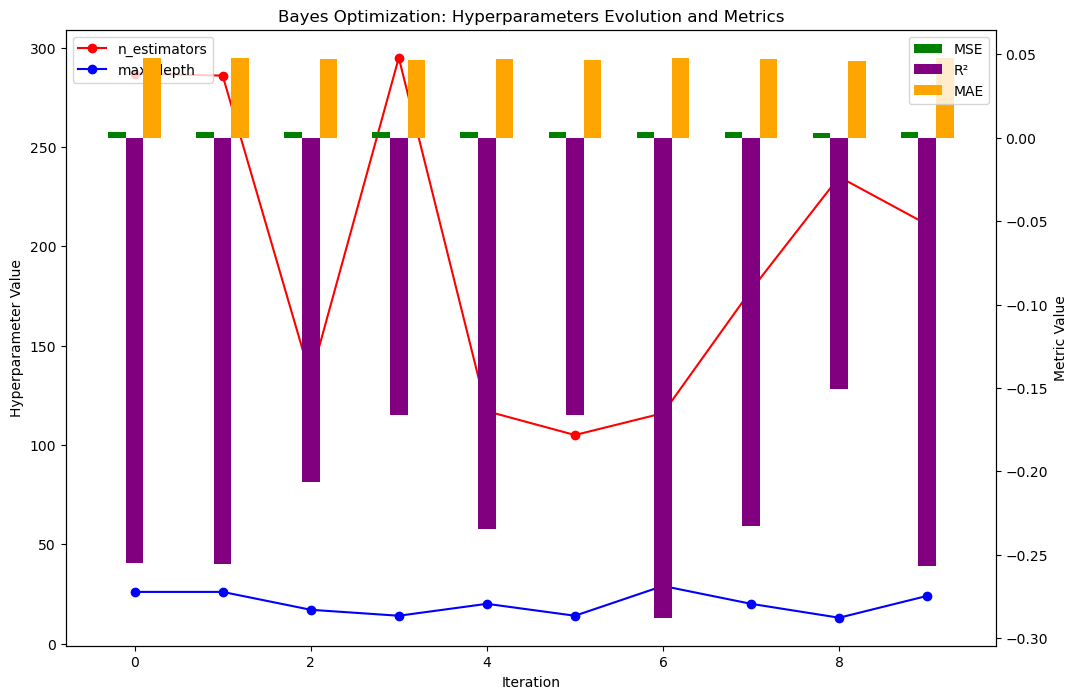

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# 从 cv_results_ 中获取参数变化和评估指标
n_estimators_values = [params['n_estimators'] for params in bayes_search.cv_results_['params']]
max_depth_values = [params['max_depth'] for params in bayes_search.cv_results_['params']]
mean_test_mse = -bayes_search.cv_results_['mean_test_mse']
mean_test_r2 = bayes_search.cv_results_['mean_test_r2']
mean_test_mae = -bayes_search.cv_results_['mean_test_mae']

# 创建图形对象和子图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 绘制折线图：参数在每次迭代中的变化
ax1.plot(range(len(n_estimators_values)), n_estimators_values, color='red', marker='o', label='n_estimators')
ax1.plot(range(len(max_depth_values)), max_depth_values, color='blue', marker='o', label='max_depth')
ax1.plot(range(len(


# 添加折线图的标题和标签
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Hyperparameter Value')
ax1.set_title('Bayes Optimization: Hyperparameters Evolution and Metrics')
ax1.legend(loc='upper left')

# 创建第二个 y 轴用于绘制评估指标的柱状图
ax2 = ax1.twinx()

# 绘制柱状图：评估指标的值
width = 0.2
x = np.arange(len(mean_test_mse))

ax2.bar(x - width, mean_test_mse, width=width, color='green', label='MSE')
ax2.bar(x, mean_test_r2, width=width, color='purple', label='R²')
ax2.bar(x + width, mean_test_mae, width=width, color='orange', label='MAE')

# 添加柱状图的标签
ax2.set_ylabel('Metric Value')
ax2.legend(loc='upper right')

# 显示图表
plt.show()


In [69]:
# %%time
# 
# # 训练四次模型，每次都使用贝叶斯优化
# all_results = []  # 用于存储所有结果
# # 开始针对 Y 的四次训练
# for i in range(4):
#     print(f"Optimizing model {i+1}/4")
# 
#     # 在新一轮循环开始前，确保关闭和清理之前的进度条
#     if 'progress_callback' in locals():
#         progress_callback.close()
#         del progress_callback
# 
#     # 实例化进度条回调函数
#     progress_callback = TqdmProgressCallback(total_iterations=n_iter, model_idx=i)
#     
#     # 开始贝叶斯优化
#     print('----------start fit----------')
#     bayes_search.fit(X, Y[:, i], callback=[progress_callback])
#     print('----------end fit----------')
# 
#     # 显式关闭进度条
#     progress_callback.close()
# 
#     # 直接从 cv_results_ 中提取每次迭代的评估指标
#     mae_scores = -bayes_search.cv_results_['mean_test_mae']  # 负号是因为贝叶斯优化会尝试最小化评分，但我们想要最大化评分，在优化中实际使用的是neg_mean_squared_error
#     r2_scores = -bayes_search.cv_results_['mean_test_r2']
#     mse_scores = bayes_search.cv_results_['mean_test_mse']
# 
#     # 将结果存储
#     result = {
#         'mse_scores': mse_scores,
#         'r2_scores': r2_scores,
#         'mae_scores': mae_scores,
#     }
#     all_results.append((result, bayes_search.best_params_))
# 
#     # 获取特征重要性
#     importance_matrix[:, i] = bayes_search.best_estimator_.feature_importances_
# 
# # 打印或保存结果
# all_results
# importance_matrix

In [ ]:
import matplotlib.pyplot as plt

# 定义要绘制的超参数名称
param_names = list(search_space.keys())
colors = ['r', 'g', 'b', 'm']  # 4个模型的颜色

# 遍历每个超参数
for param_name in param_names:
    plt.figure(figsize=(10, 6))

    # 对于每个模型，获取其参数历史，并绘制在同一张图上
    for i in range(4):
        # 获取当前模型对应的参数历史
        params_history = []
        for best_index in range(len(all_results[i][0]['mse_scores'])):
            params_history.append(bayes_search.cv_results_['params'][best_index])

        param_values = [params[param_name] for params in params_history]

        if isinstance(search_space[param_name], Categorical):
            # 如果超参数是类别类型，绘制类别标签
            unique_categories = list(set(param_values))
            category_to_num = {category: num for num, category in enumerate(unique_categories)}
            num_values = [category_to_num[val] for val in param_values]
            plt.plot(range(len(num_values)), num_values, marker='o', color=colors[i], label=f'Model {i+1}')
            plt.yticks(list(category_to_num.values()), list(category_to_num.keys()))
        else:
            # 如果是数值类型，直接绘制
            plt.plot(range(len(param_values)), param_values, marker='o', color=colors[i], label=f'Model {i+1}')

    plt.title(f'{param_name} evolution during Bayes Optimization')
    plt.xlabel('Iteration')
    plt.ylabel(param_name)
    plt.legend()  # 显示图例
    plt.grid(True)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 定义评估指标和对应的键
metrics = ['MSE', 'R²', 'MAE']
metric_keys = ['mse_scores', 'r2_scores', 'mae_scores']

# 创建一个包含多个子图的图表
fig, axs = plt.subplots(len(metrics), 1, figsize=(14, 8 * len(metrics)))

# 遍历每个评估指标并绘制子图
for idx, (metric_name, metric_key) in enumerate(zip(metrics, metric_keys)):
    for i, (result, _) in enumerate(all_results):
        axs[idx].plot(range(len(result[metric_key])), result[metric_key], label=f'Model {i+1}', marker='o')

    axs[idx].set_title(f'{metric_name} evolution during Bayes Optimization')
    axs[idx].set_xlabel('Iteration')
    axs[idx].set_ylabel(metric_name)
    axs[idx].legend()
    axs[idx].grid(True)

# 自动调整子图布局，避免重叠
plt.tight_layout()

# 显示图表
plt.show()


In [89]:
# 初始化用于存储参数和评估指标的列表
params_list = []
metrics_list = []

# 遍历每个模型的结果
for i, (result, best_params) in enumerate(all_results):
    # 将最佳参数保存到 params_list 中
    best_params['Model'] = f'Model {i+1}'
    params_list.append(best_params)

    # 将最终的评估指标保存到 metrics_list 中
    metrics = {
        'Model': f'Model {i+1}',
        'MSE': result['mse_scores'][-1],
        'R²': result['r2_scores'][-1],
        'MAE': result['mae_scores'][-1],
    }
    metrics_list.append(metrics)

# 将参数和评估指标分别转换为 DataFrame
params_df = pd.DataFrame(params_list)
metrics_df = pd.DataFrame(metrics_list)

In [90]:
params_df

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Model
0,11,None,3,5,242,Model 1
1,14,log2,2,3,259,Model 2
2,14,sqrt,3,9,256,Model 3
3,12,log2,4,8,236,Model 4


In [91]:
metrics_df

,Model,MSE,R²,MAE
0,Model 1,-0.003299,0.209065,0.047016
1,Model 2,-0.004466,0.432576,0.054314
2,Model 3,-0.250980,0.267409,0.409451
3,Model 4,-0.000177,0.296136,0.010733


In [ ]:
%%time
# 开始针对 Y 的四次训练
for i in range(4):
    print(f"Optimizing model {i+1}/4")

    # 在新一轮循环开始前，确保关闭和清理之前的进度条
    if 'progress_callback' in locals():
        progress_callback.close()
        del progress_callback

    # 实例化进度条回调函数
    # progress_callback = TqdmProgressCallback(total_iterations=n_iter, model_idx=i)
    progress_callback = TqdmTimeProgressCallback(total_iterations=n_iter, model_idx=i)

    # 开始贝叶斯优化
    print('----------start fit----------')
    bayes_search.fit(X, Y[:, i], callback=[progress_callback])
    print('----------end fit----------')

    # 显式关闭进度条
    progress_callback.close()

    # 直接从 cv_results_ 中提取每次迭代的评估指标
    mae_scores = -bayes_search.cv_results_['mean_test_mae']  # 负号是因为贝叶斯优化会尝试最小化评分，但我们想要最大化评分，在优化中实际使用的是neg_mean_squared_error
    r2_scores = -bayes_search.cv_results_['mean_test_r2']
    mse_scores = bayes_search.cv_results_['mean_test_mse']

    # 将结果存储
    result = {
        'mse_scores': mse_scores,
        'r2_scores': r2_scores,
        'mae_scores': mae_scores,
    }
    all_results.append((result, bayes_search.best_params_))

    # 获取特征重要性
    importance_matrix[:, i] = bayes_search.best_estimator_.feature_importances_

# 打印或保存结果
